# Project 5 - Continuous Speech Recognition

----
Authors: Junkai Man, Tzu-Liang Huang

Time: Feb 25, 2022


## Problem1

In [63]:
import numpy as np

def load_model(model_filename):
    """
        model_filename: filename of the model, should be a npz file containing all trans_mat and hmm_states of each word

    """
    nums = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

    load_file = np.load(model_filename)
    # assuming all the models have the same state number
    N_STATE = load_file['zero_trans'].shape[0] - 2      # minus two buffer trans_probs

    trans_dict = {}
    means_dict = {}
    vars_dict = {}

    for idx, num in enumerate(nums):
        old_trans_mat = load_file[f'{num}_trans']       # 7x5 matrix
        new_trans_mat = np.empty((N_STATE, N_STATE))    # 5x5 matrix
        new_trans_mat.fill(-1 * np.inf)
        for j in range(N_STATE):
            if j > 2:
                subst = old_trans_mat[2+j, 0:5-j]
            else:
                subst = old_trans_mat[2+j, :]
            new_trans_mat[j, j:min(j+3, N_STATE)] = subst
        trans_dict[f'{num}'] = new_trans_mat

        hmm_means_vars = load_file[f'{num}_hmm']
        means_dict[f'{num}'] = hmm_means_vars[::2]
        vars_dict[f'{num}'] = hmm_means_vars[1::2]
    return trans_dict, means_dict, vars_dict


In [155]:
from os import listdir

def load_test_queries(file_dir):
    file_list = listdir(file_dir)
    if '.DS_Store' in file_list:
        file_list.remove('.DS_Store')
    test_queries_dict = {}
    for item in file_list:
        # print(item)
        test_queries_dict[f'{item[:-4]}'] = np.loadtxt(f'{file_dir}/{item}')
    return test_queries_dict

In [65]:
def build_template_for_problem1(trans_dict, means_dict, vars_dict):
    nums = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

    # Number of states for each HMM
    N_STATE = 5
    N_MFCC = 39

    n_layers = 7            # can handle 7 digits
    
    # First add a NE state
    template_height = 1
    for i in range(n_layers):
        if i == 0:  want_nums = nums[2:]
        else:       want_nums = nums
        for num in want_nums:
            template_height += N_STATE
        template_height += 1                   # add a NE state

    full_trans_mat = np.full((template_height, template_height), np.inf)

    template_indicator = []
    template_indicator.append('*')
    hmm_means_matrix = np.zeros((1, N_MFCC))
    hmm_vars_matrix = np.zeros((1, N_MFCC))
    start_state_idx = [[] for _ in range(n_layers)]
    end_state_idx = [[] for _ in range(n_layers)]
    nes_idx = [0]

    for i in range(n_layers):
        if i == 0:  want_nums = nums[2:]
        else:       want_nums = nums
        for num in want_nums:
            curr = len(template_indicator)
            start_state_idx[i].append(curr)
            end_state_idx[i].append(curr + N_STATE - 1)
            regional_trans_mat = trans_dict[f'{num}'].T
            template_indicator.extend([f'{num}'] * N_STATE) 
            hmm_means_matrix = np.vstack((hmm_means_matrix, means_dict[f'{num}']))
            hmm_vars_matrix = np.vstack((hmm_vars_matrix, vars_dict[f'{num}']))
            full_trans_mat[curr: curr+N_STATE, curr:curr+N_STATE] = regional_trans_mat

        template_indicator.append('*')      # NES
        hmm_means_matrix = np.vstack((hmm_means_matrix, np.zeros((1, N_MFCC))))
        hmm_vars_matrix = np.vstack((hmm_vars_matrix, np.zeros((1, N_MFCC))))
        nes_idx.append(len(template_indicator)-1)

    # Taking from peer tutor's advice, we manually assign the 0 transition cost for each NES
    prev_nes_idx = 0
    next_nes_idx = 1
    for i in range(n_layers):
        for s in start_state_idx[i]:
            full_trans_mat[s, nes_idx[prev_nes_idx]] = 0    # transit from NES to start state
        for e in end_state_idx[i]:
            full_trans_mat[nes_idx[next_nes_idx], e] = 0    # transit from end state to NES
        prev_nes_idx += 1
        next_nes_idx += 1

    # Here, add the transition cost 0 from the 0th NES to the 3th NES so that we can skip the first three
    full_trans_mat[nes_idx[3], nes_idx[0]] = 0
    return template_indicator, full_trans_mat, hmm_means_matrix, hmm_vars_matrix


In [166]:
from scipy.spatial.distance import cdist

def continuous_rec(query, template_indicator, transition, means, vars, end_points=None):
    n_cols = len(query)
    n_rows = transition.shape[0]
    cost_mat = np.full((n_rows, n_cols), np.inf)
    path_mat = np.zeros((n_rows, n_cols), dtype=tuple)
    for c in range(n_cols):
        for r in range(n_rows):
            path_mat[r, c] = (0, 0)

    dist_mat = np.zeros((n_rows, n_cols))
    N_MFCC = means.shape[1]
    for i in range(n_rows):
        if template_indicator[i] == '*':
            continue
        D = N_MFCC
        means = hmm_means[i, :]
        vars = hmm_vars[i, :]
        cov_I = np.linalg.inv(np.diag(vars))
        mahala_dist = cdist(np.matrix(means), query, 'mahalanobis', VI=cov_I)
        dist_mat[i] = 0.5 * mahala_dist + D * 0.5 * np.log(2 * np.pi) + 0.5 * np.prod(vars)

    for c in range(n_cols):
        for r in range(n_rows):
            if r == 0 and c == 0:
                cost_mat[0, 0] = dist_mat[0, 0]
                continue
            prev_costs = []
            from_points = []
            for origin in range(n_rows):
                # Taking advice from the peer tutor, we simplified three types of dtw (right, diag, super-diag)
                # to only one type (parent) by only considering whether it can transit from the "origin" state
                # i.e. whether the transition cost from origin -> r is infinity or not
                if np.isinf(transition[r, origin]):
                    continue

                if template_indicator[origin] == '*' or template_indicator[r] == '*':
                    # if the origin is a NES or the parent
                    # note that we've already excluded the cases where origin cannot transit to r
                    prev_costs.append(transition[r, origin] + cost_mat[origin, c])
                    from_points.append([origin, c])
                else:
                    prev_costs.append(transition[r, origin] + cost_mat[origin, c - 1])
                    from_points.append([origin, c - 1])
            
            if len(prev_costs) == 0:
                continue
            min_idx = np.argmin(prev_costs)
            origin_point = from_points[min_idx]
            path_mat[r, c] = origin_point
            cur_cost = dist_mat[r, c] + prev_costs[min_idx]
            cost_mat[r, c] = np.min([cost_mat[r, c], cur_cost])
    
    if end_points is None:
        end_points = [(-1, -1)]
    
    best_cost = np.inf
    best_end_point = []
    for end_point in end_points:
        if best_cost >= cost_mat[end_point]:
            best_cost = cost_mat[end_point]
            best_end_point = end_point
    
    i, j = best_end_point
    path = []
    while j != 0:
        i, j = path_mat[i, j]
        path.append([i, j])


    # return the result
    from itertools import groupby
    path = np.array(path[::-1])[:, 0]
    result = [i[0] for i in groupby(path)]
    final_result = []
    for i in range(len(result)):
        final_result.append(template_indicator[result[i]])
    final_result = [i[0] for i in groupby(final_result)]
    final_result = list(filter(lambda x: x != '*', final_result))
    return cost_mat, path, final_result, dist_mat


In [185]:
"""
    Main
"""
num_to_digit = {"zero": 0, "one": 1, "two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9}

# Load models
trans_dict, means_dict, vars_dict = load_model('npz_save/nums_hmm_1g.npz')

# Load test_queries
# for convenience, we just store them in mfcc lists
queries = load_test_queries('./test_data')

# Prepare template
template_indicator, trans_mat, hmm_means, hmm_vars = build_template_for_problem1(trans_dict, means_dict, vars_dict)

# Test accuracy
total_digits = 10 * 4 + 15 * 7
total_sentences = 25

digit_cnt = 0
sentence_cnt = 0
for key in queries.keys():
    cost_mat, path, final_result, dist_mat = continuous_rec(queries[f'{key}'], template_indicator, trans_mat, hmm_means, hmm_vars)
    digits = []
    for num in final_result:
        digits.append(num_to_digit[num])

    for i in range(len(key)):
        if f'{digits[i]}' == f'{key[i]}':
            digit_cnt += 1
    
    digits = [str(d) for d in digits]
    if ''.join(digits) == key:
        sentence_cnt += 1

print("========Accuracy========")
print("Digit accuracy:", digit_cnt / total_digits)
print("Sentence accuracy:", sentence_cnt / total_sentences)


========Accuracy========
Digit accuracy: 0.9448275862068966
Sentence accuracy: 0.68


## Problem2

In [199]:
import matplotlib.pyplot as plt
def build_template_for_problem2(trans_dict, means_dict, vars_dict):
    nums = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

    # Number of states for each HMM
    N_STATE = 5
    N_MFCC = 39

    n_layers = 1            # can handle 7 digits
    
    # First add a NE state
    template_height = 1
    for i in range(n_layers):
        want_nums = nums
        for num in want_nums:
            template_height += N_STATE
        template_height += 1                   # add a NE state

    full_trans_mat = np.full((template_height, template_height), np.inf)

    template_indicator = []
    template_indicator.append('*')
    hmm_means_matrix = np.zeros((1, N_MFCC))
    hmm_vars_matrix = np.zeros((1, N_MFCC))
    start_state_idx = [[] for _ in range(n_layers)]
    end_state_idx = [[] for _ in range(n_layers)]
    nes_idx = [0]

    for i in range(n_layers):
        want_nums = nums
        for num in want_nums:
            curr = len(template_indicator)
            start_state_idx[i].append(curr)
            end_state_idx[i].append(curr + N_STATE - 1)
            regional_trans_mat = trans_dict[f'{num}'].T
            template_indicator.extend([f'{num}'] * N_STATE) 
            hmm_means_matrix = np.vstack((hmm_means_matrix, means_dict[f'{num}']))
            hmm_vars_matrix = np.vstack((hmm_vars_matrix, vars_dict[f'{num}']))
            full_trans_mat[curr: curr+N_STATE, curr:curr+N_STATE] = regional_trans_mat

        template_indicator.append('*')      # NES
        hmm_means_matrix = np.vstack((hmm_means_matrix, np.zeros((1, N_MFCC))))
        hmm_vars_matrix = np.vstack((hmm_vars_matrix, np.zeros((1, N_MFCC))))
        nes_idx.append(len(template_indicator)-1)

    # Taking from peer tutor's advice, we manually assign the 0 transition cost for each NES
    prev_nes_idx = 0
    next_nes_idx = 1
    for i in range(n_layers):
        for s in start_state_idx[i]:
            full_trans_mat[s, nes_idx[prev_nes_idx]] = 0    # transit from NES to start state
        for e in end_state_idx[i]:
            full_trans_mat[nes_idx[next_nes_idx], e] = 0    # transit from end state to NES
        prev_nes_idx += 1
        next_nes_idx += 1
    
    # Transit from the last one to the first one
    full_trans_mat[nes_idx[0], nes_idx[-1]] = 0
    plt.figure(figsize=(3, 3), dpi=130)
    plt.matshow(full_trans_mat, fignum=1, origin='lower')
    plt.show()
    return template_indicator, full_trans_mat, hmm_means_matrix, hmm_vars_matrix


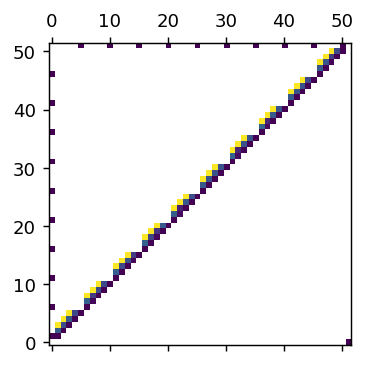

In [200]:
"""
    Main
"""
num_to_digit = {"zero": 0, "one": 1, "two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9}

# Load models
trans_dict, means_dict, vars_dict = load_model('npz_save/nums_hmm_1g.npz')

# Load test_queries
# for convenience, we just store them in mfcc lists
queries = load_test_queries('./test_data')

# Prepare template
template_indicator, trans_mat, hmm_means, hmm_vars = build_template_for_problem2(trans_dict, means_dict, vars_dict)


# test
cost_mat, path, final_result, dist_mat = continuous_rec(queries['4958'], template_indicator, trans_mat, hmm_means, hmm_vars)


In [204]:
final_result

['four']

failed.

Make the last non-emitting state transit back to the first one.

But still no clue why this program will only recognize the very first digit

We'd like to hear some feedbacks... and debugs...

In [203]:
path

array([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25])